# Investigating Adding Heat Pump Performance Curve Parameters as Training Features: A Case Study on the 3 Ductless RFP HPs

Conclusion: Adding these parameters does show promise and improve performance, and in fact we should definitely not be training on these hps with custom performance curves without these features. 

In [0]:
%pip install mlflow==2.13.0
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached mlflow-2.13.0-py3-none-any.whl (25.0 MB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl (114 kB)
  Using cached opentelemetry_api-1.31.1-py3-none-any.whl (65 kB)
  Using cached opentelemetry_sdk-1.31.1-py3-none-any.whl (118 kB)
  Using cached alembic-1.15.1-py3-none-any.whl (231 kB)
  Using cached docker-7.1.0-py3-none-any.whl (147 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached typing_extensions-4.13.0-py3-none-any.whl (45 kB)
  Using cached graphql_core-3.2.6-py3-none-any.whl (203 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl (16 kB)
  Using cached Deprecated-1.2.18-py2.py3-none-any.whl (10.0 kB)
  Using cached importlib_metadata-7.2.1-py3-none-any.whl (25 kB)
  Using cached opentelemetry_semantic_conventions-0.52b1-py3-none-any.whl (183 kB)
  Attempting uninstall: typing-extensions
    Found existing installatio

In [0]:
import mlflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import matplotlib.lines as mlines

import src.globals as g
from src.datagen import DataGenerator, load_data
from src.surrogate_model import SurrogateModel

2025-03-27 14:57:28.086188: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Visualize Performance Metrics for various OEM Heat Pumps

We first just want to visualize how the metrics compare for the 3 RFP heat pumps. 

In [0]:
#pull table to heat pump features for each building and upgrade
hp_features_by_building_upgrade= (
    spark.table(f"{g.BUILDING_FEATURE_TABLE}_perf_curve_param_oem_hp_only_experiment")
    .withColumn("zone_type", F.regexp_extract("hvac_heating_efficiency", r"(MZ|SZ)", 0))
)
hp_features_by_building_upgrade = hp_features_by_building_upgrade.select(
    "building_id", "upgrade_id", "zone_type",
    hp_features_by_building_upgrade.colRegex("`.*_(cop|capacity)_.*|`"), 
    "heating_efficiency_nominal_percentage", "cooling_efficiency_eer"
).toPandas()

# divide seer by 10 so it is roughly the same scale as the others for plotting 
hp_features_by_building_upgrade["cooling_efficiency_eer/5"] = hp_features_by_building_upgrade["cooling_efficiency_eer"] / 5
hp_features_by_building_upgrade.drop("cooling_efficiency_eer", axis = 1, inplace=True)

In [0]:
#get a table of heat pump specs for each upgrade and zone type in long format
hp_features_by_upgrade_zone_long = hp_features_by_building_upgrade.groupby(
    ["upgrade_id", 'zone_type'], as_index=False).first().melt(
        id_vars=["upgrade_id", "zone_type"],
        value_vars=hp_features_by_building_upgrade.columns[3:].tolist())

Most noteably, the York CCHP (15.06) has reasonably high overall rated heating and cooling efficiencies (`heating_efficiency_nominal_percentage` - derived from HSPF, and `cooling_efficiency_eer`), but has fairly low COPs at min speed. This is particulary true at for the multi zone heat pump, even more so at low temps. We know that the this heat pump was not very energy efficient compared to the other two, but that this was not represented in these overall rated metrics. Thus, we know it is important for the model to see all of these performnace curve features in order to accurately predict energy consumption. These 3 heat pumps then provide a good test of whether the model can learn from these performance curve parameters.

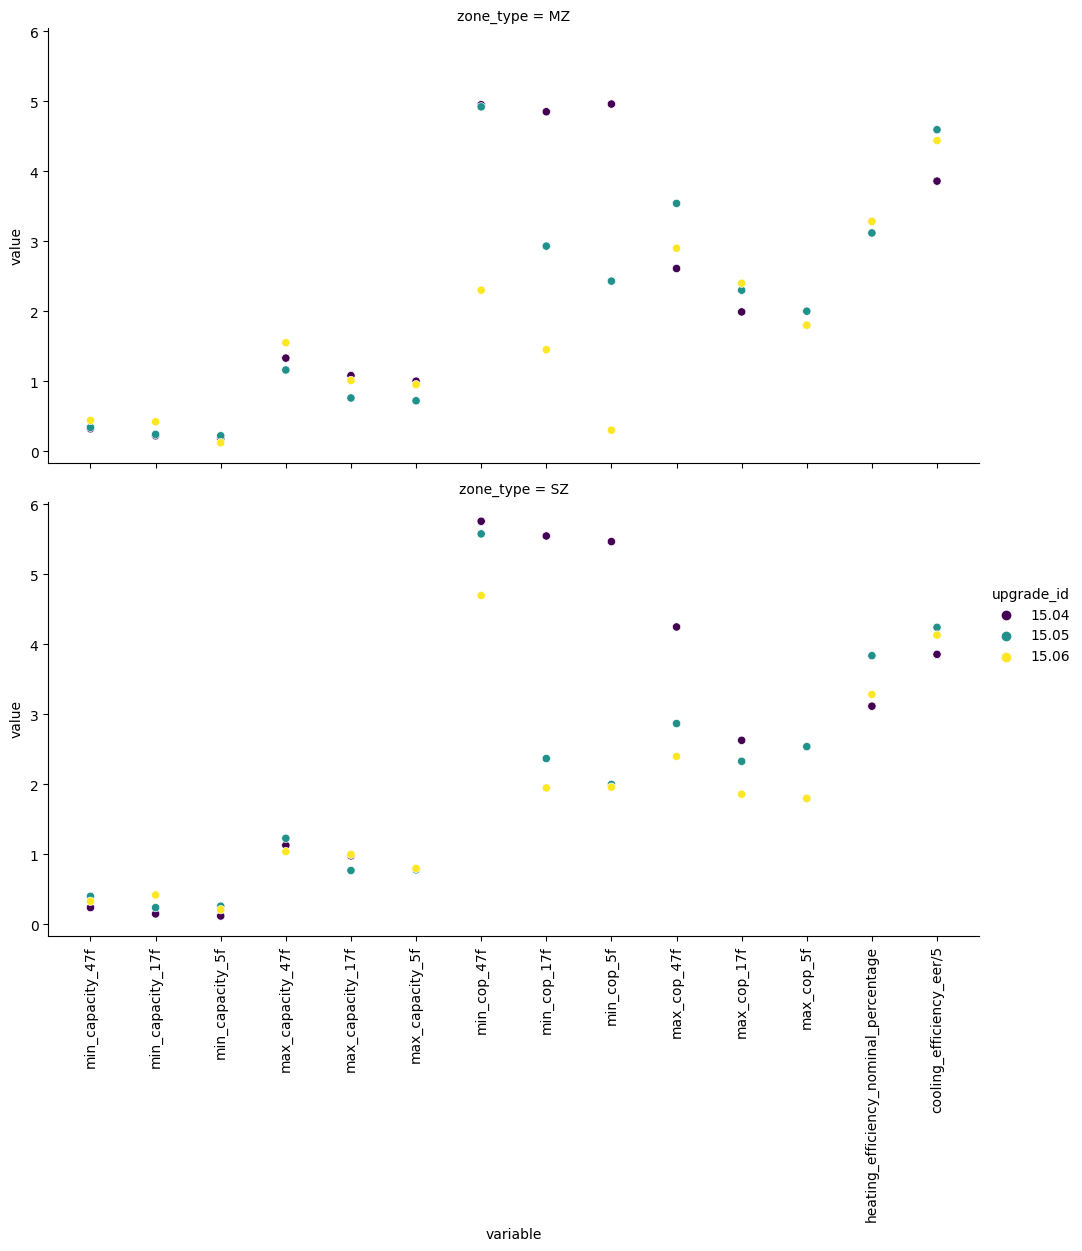

In [0]:
# plot all the metrics so we can compare them visually
ax = sns.relplot(data=hp_features_by_upgrade_zone_long , x="variable", y="value", hue="upgrade_id", palette='viridis', row = 'zone_type', height=5, aspect=2)
ax.tick_params(axis='x', labelrotation=90)

## Examine overall performance with and without perfomance curve params features

We trained two models on just the OEM heat pumps displayed above: one model saw just all of the same base features as the model has been trained on before, including the SEER and HSPF. One model also saw all the performance curve metrics, that is the capacity retention and coefficient of performance (COP) at min and max speeds and at 5F, 17F, and 47F outdoor temp.

We first compare the overall performance. 


In [0]:
version_name_base = "oem_hp_only_experiment"
version_name_w_perf_curve_features = "perf_curve_param_oem_hp_only_experiment"

In [0]:
#lets read in previously computed aggregated metrics
aggregated_metrics = pd.read_csv(str(g.GCS_ARTIFACT_PATH / version_name_base / "metrics_by_upgrade_type.csv"))
aggregated_metrics_w_perf_curve_features  = pd.read_csv(str(g.GCS_ARTIFACT_PATH / version_name_w_perf_curve_features  / "metrics_by_upgrade_type.csv"))

# drop all the columns regarding savings and fuel types-- these are meaningless since we don't have baseline and everything is electric
non_savings_columns = [c for c in aggregated_metrics.columns if 'Savings' not in c]
aggregated_metrics = aggregated_metrics.loc[aggregated_metrics.Type=='Total', non_savings_columns].sort_values('Upgrade ID').set_index(['Type', 'Upgrade ID'])
aggregated_metrics_w_perf_curve_features = aggregated_metrics_w_perf_curve_features.loc[aggregated_metrics_w_perf_curve_features.Type=='Total', non_savings_columns].sort_values('Upgrade ID').set_index(['Type', 'Upgrade ID'])

Overall we see *very* good performance for both models, but lower error for the model that included the performance curve params. But was this just a lucky run? Did the model actually learn from these? And given that these heat pump samples are much less diverse than our full traning set, is the model just getting good at predicting these ductless single/multi zone cchps in general or is it actually able to distinguish between them?

In [0]:
aggregated_metrics

Median Abs Error  Median APE  ...  Mean APE  Weighted Mean APE
Type  Upgrade ID                                ...                             
Total 15.04                  644.0         4.2  ...       5.1                4.7
      15.05                  638.0         4.1  ...       5.0                4.5
      15.06                  693.0         3.8  ...       4.8                4.3

[3 rows x 5 columns]

In [0]:
aggregated_metrics_w_perf_curve_features

Median Abs Error  Median APE  ...  Mean APE  Weighted Mean APE
Type  Upgrade ID                                ...                             
Total 15.04                  442.0         2.9  ...       3.9                3.9
      15.05                  442.0         2.8  ...       3.8                3.8
      15.06                  538.0         3.0  ...       4.0                3.9

[3 rows x 5 columns]

In [0]:
aggregated_metrics_w_perf_curve_features - aggregated_metrics

Median Abs Error  Median APE  ...  Mean APE  Weighted Mean APE
Type  Upgrade ID                                ...                             
Total 15.04                 -202.0        -1.3  ...      -1.2               -0.8
      15.05                 -196.0        -1.3  ...      -1.2               -0.7
      15.06                 -155.0        -0.8  ...      -0.8               -0.4

[3 rows x 5 columns]

## Can the surrogate model actually distinguish between these heat pumps?

In [0]:
def plot_predictions(predictions):
    """
    Plots the actual vs predicted values for different upgrade IDs and zone types.

    Parameters:
    predictions (DataFrame): A Spark DataFrame containing the columns 'actual', 'prediction', 
                             'building_id', 'zone_type', and 'upgrade_id_predicted'.

    Returns:
    None: Displays the lmplot for the predictions.
    """
    predictions_all_upgrade_ids = predictions.drop("prediction", axis=1).merge(
        predictions.drop("actual", axis=1), on=["building_id", "zone_type"], suffixes=["", "_predicted"]
    )

    # Filter the data as you originally did
    df_filtered = (
        predictions_all_upgrade_ids.groupby(["upgrade_id", "zone_type"])
        .apply(
            lambda group: group[
                (group["actual"] > group["actual"].quantile(0.05))
                & (group["actual"] < group["actual"].quantile(0.95))  # Remove bottom 5%  # Remove top 5%
            ]
        )
        .reset_index(drop=True)
    )

    # Create the lmplot
    g = sns.lmplot(
        x="actual",
        y="prediction",
        hue="upgrade_id_predicted",
        col="upgrade_id",
        row="zone_type",
        data=df_filtered,
        facet_kws={"sharex": False, "sharey": False},
        scatter_kws={"s": 0.05, "alpha": 0.2},
    )

    # Add a y=x line to each facet
    for ax in g.axes.flat:
        ax.plot(ax.get_xlim(), ax.get_xlim(), color="black", ls="--", label="y=x", lw=3)

    # Create a color palette for the hue categories
    palette = sns.color_palette("deep", n_colors=len(df_filtered["upgrade_id_predicted"].unique()))

    # Customize the legend to use solid color patches
    handles = [
        mlines.Line2D([0], [0], marker="o", color="w", markerfacecolor=palette[i], markersize=10, label=str(hue))
        for i, hue in enumerate(df_filtered["upgrade_id_predicted"].unique())
    ]

    # Remove the default legend and add the custom one
    g._legend.remove()
    g.fig.legend(handles=handles, title="Prediction Upgrade ID", loc="center", bbox_to_anchor=(0.5, -0.05), ncol=3)

    # Show the plot
    plt.show()

In [0]:
# get mapping of building id to zone type
building_upgrade_zone_type = hp_features_by_building_upgrade[["building_id", "upgrade_id", "zone_type"]]

# read in predictions on full test set for each model
predictions_base = pd.read_csv(str(g.GCS_ARTIFACT_PATH / version_name_w_perf_curve_features / "prediction_metrics_test_set.csv")).query(
    "fuel == 'total'"
)[["building_id", "upgrade_id", "actual", "prediction"]]

predictions_w_perf_curve = pd.read_csv(str(g.GCS_ARTIFACT_PATH / version_name_w_perf_curve_features / "prediction_metrics_test_set.csv")).query(
    "fuel == 'total'"
)[["building_id", "upgrade_id", "actual", "prediction"]]

# add a column for the zone type (multi zone or single zone)
predictions_base = predictions_base.merge(building_upgrade_zone_type, on = ["building_id", "upgrade_id"])
predictions_w_perf_curve = predictions_w_perf_curve.merge(building_upgrade_zone_type, on = ["building_id", "upgrade_id"])


We next look at plots of the actual vs the predicted values by (upgrade, zone type), where the dotted black y=x line indicates perfect prediction. But for each, we not only plot the actuals against the predictions for the given upgrade id, we also plot the predictions for the other upgrade ids. The predictions and linear trendline for each upgrade is shown in a given color. If the model can distingish between the heat pumps, we would expect to see different trendlines and we would expect to see that the dotted black line (y=x) lines up with the trendline corresponding to the correct (upgrade, zone) in the given facet.

For both models, we do indeed do see this, most clearly with the York heat pump (15.06) and particularly with the more inefficient multi zone heat york yeat pump. There is much less distinction for the other two, but there is still some. In fact these plots for these two models are almost indistinguishable, and this then begs the the question: for the model that *didn't* see the performance metrics, how did it learn that the york heat pump (green) is so more inefficient than the others if it only got to see the rated efficiencies, which did not reflect this?

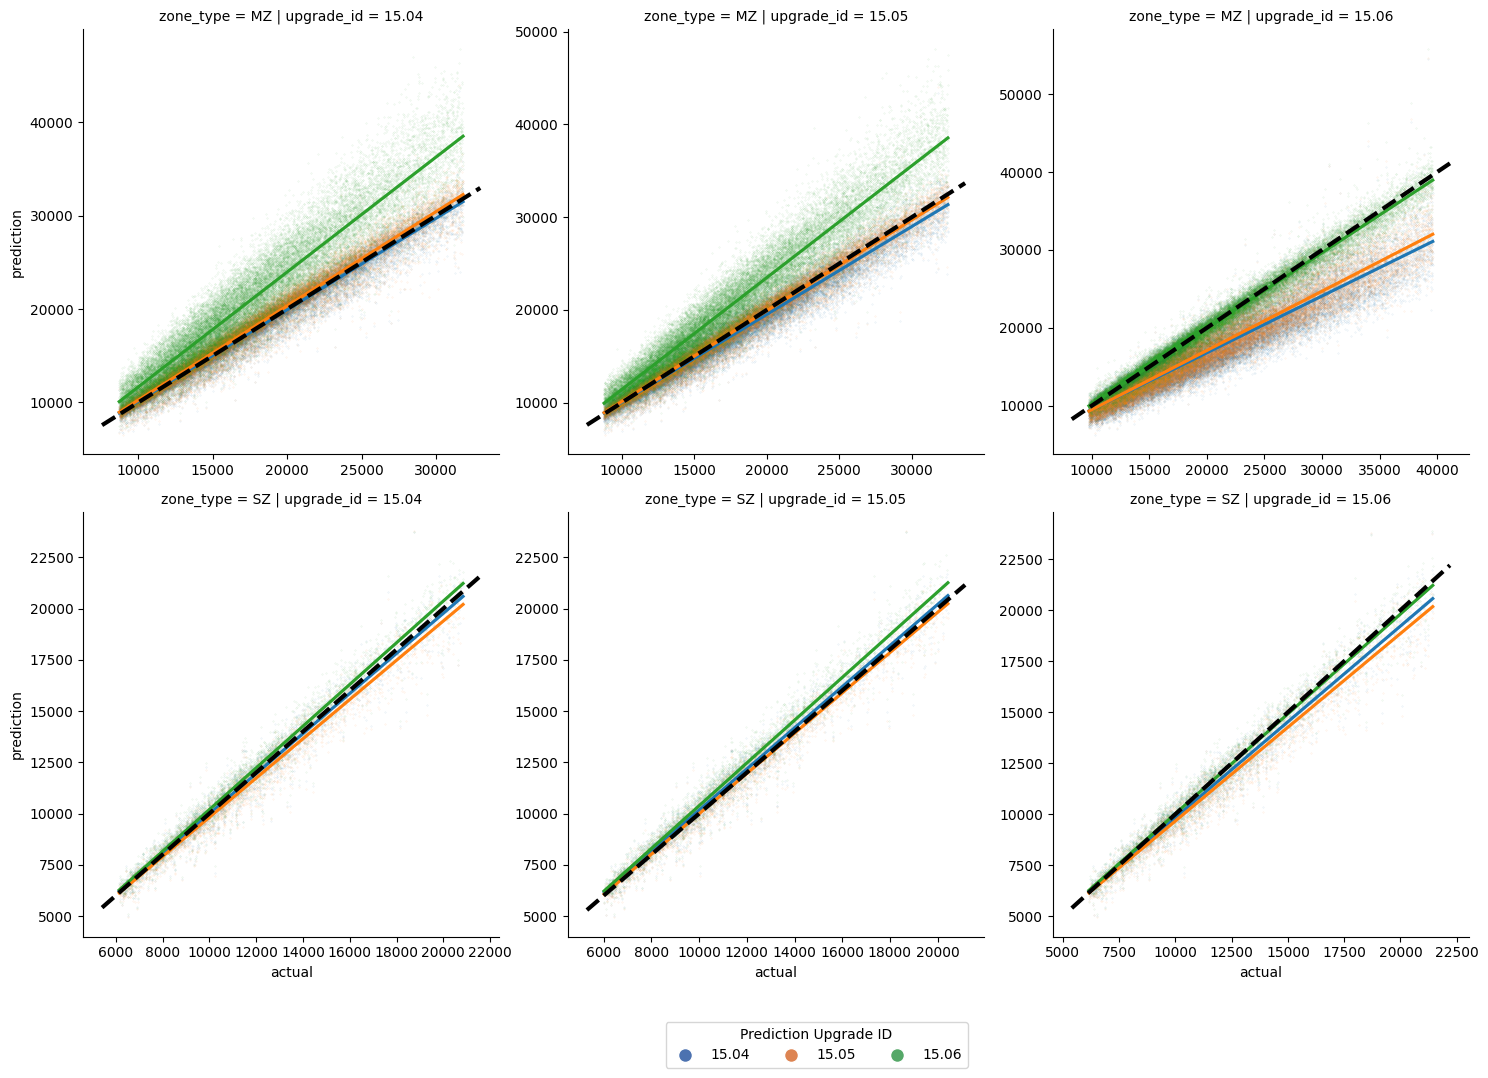

In [0]:
plot_predictions(predictions_w_perf_curve)

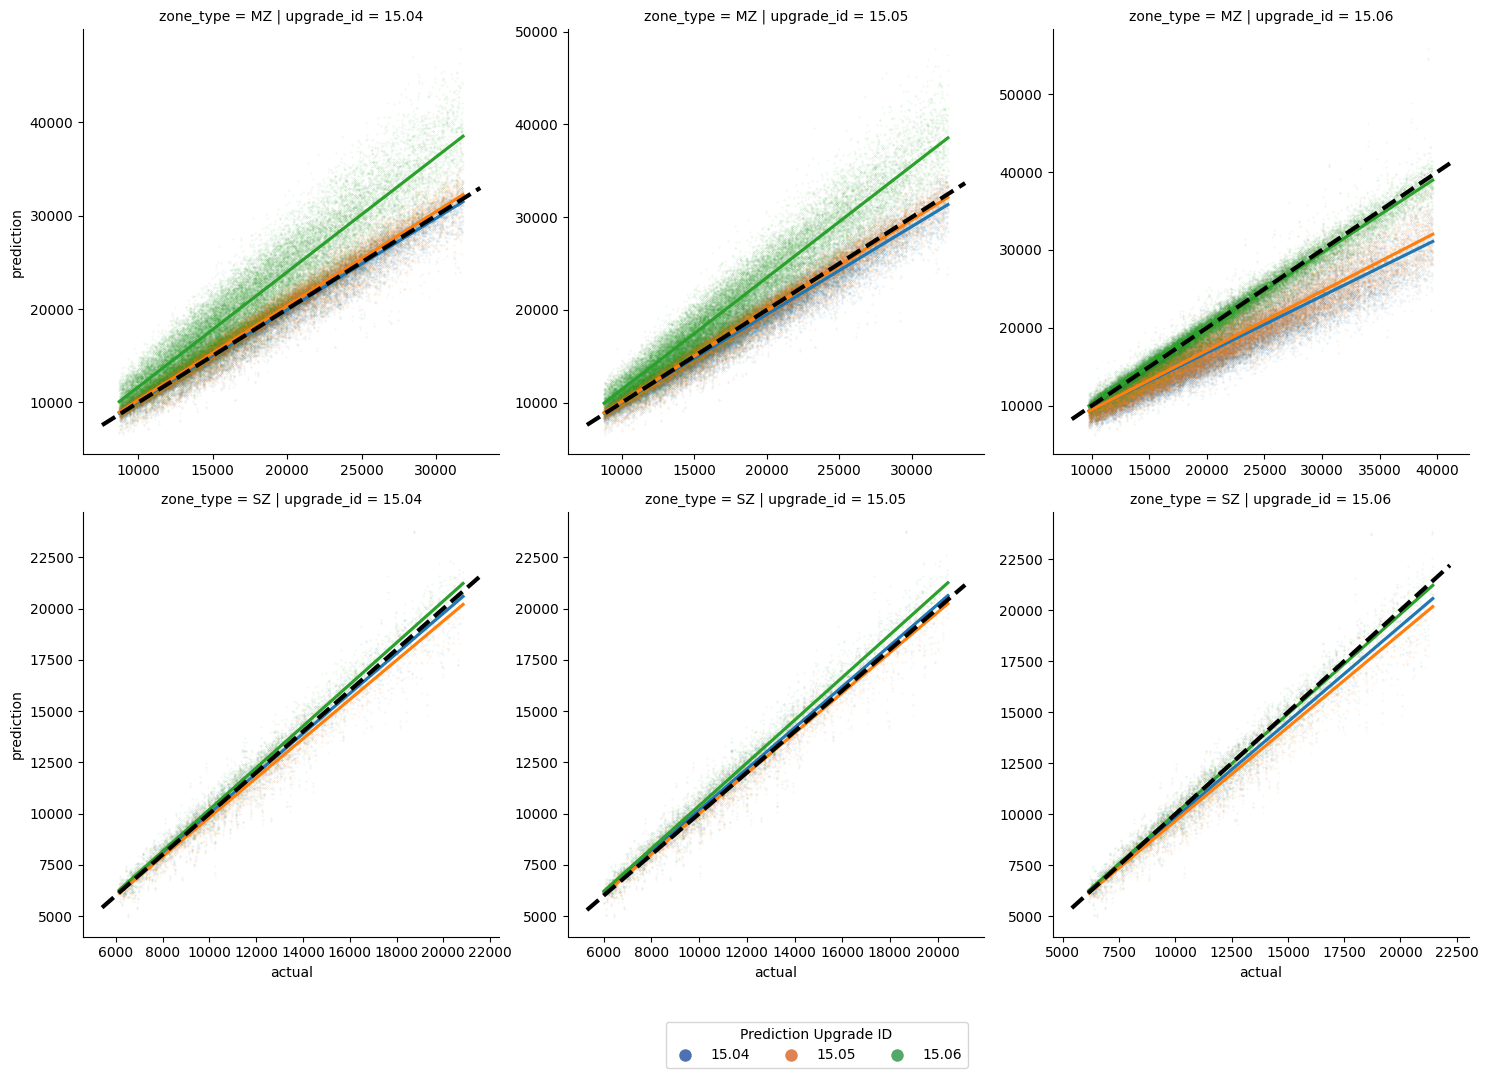

In [0]:
plot_predictions(predictions_base )

### What relationships is the model actually learning between energy conusmption and performance metrics? 

We're now going to vary the various performance metrics while holding all else equal and look at the impact it has on predicted energy consumption for each model. It gives us insight into the relationships the model has learned. 

In [0]:
def analyze_feature_impact(model, inference_data, feature_name, grid_values=None, num_points=20):
    """
    Analyze how model predictions change when varying one feature (batch version).

    Args:
        model: Loaded TensorFlow model
        inference_data: Original DataFrame with samples
        feature_name: Name of feature to vary
        grid_values: Specific values to test (optional)
        num_points: Number of points if grid_values not provided

    Returns:
        DataFrame with results and displays a plot
    """
    # Create a copy of the original data to avoid modifying it
    original_data = inference_data.copy()

    # If grid values not provided, create a linear space
    if grid_values is None:
        min_val = original_data[feature_name].min()
        max_val = original_data[feature_name].max()
        grid_values = np.linspace(min_val, max_val, num_points)

    # Create all modified datasets at once
    batch_data = pd.concat([original_data.assign(**{feature_name: value}) for value in grid_values], ignore_index=True)

    # Add identifier for which grid value each row belongs to
    batch_data["_grid_value"] = np.repeat(grid_values, len(original_data))

    # Run single batch prediction
    predictions = np.nansum(model.predict(batch_data), axis=1)

    # Add predictions to the batch data
    batch_data["_prediction"] = predictions

    # Group by grid value and calculate statistics
    results = (
        batch_data.groupby("_grid_value")["_prediction"].agg(["mean", "median", "std", "min", "max"]).reset_index()
    )
    results.columns = [
        "feature_value",
        "mean_prediction",
        "median_prediction",
        "std_prediction",
        "min_prediction",
        "max_prediction",
    ]

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(results["feature_value"], results["mean_prediction"], label="Mean Prediction", color="blue")
    plt.fill_between(
        results["feature_value"],
        results["mean_prediction"] - results["std_prediction"],
        results["mean_prediction"] + results["std_prediction"],
        alpha=0.2,
        color="blue",
    )

    plt.xlabel(feature_name)
    plt.ylabel("Predicted Total Energy Consumption")
    plt.title(f"Impact of {feature_name} on Predicted Total Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

In [0]:
# load test data, lets just do 100 samples
_, _, test_data = load_data(n_test=100)
test_gen = DataGenerator(test_data)
# reload the training set
test_set = test_gen.init_training_set(train_data=test_data, exclude_columns=["weather_file_city"]).load_df()
# convert from pyspark to pandas so we can run inference
inference_data = test_set.toPandas()

In [0]:
# Load the two trained surrogate models
sm = SurrogateModel()
model = mlflow.pyfunc.load_model(model_uri=sm.get_model_uri(run_id="af6dd687ec494a97a7ab32fcc542f67e"))
model_w_perf_metrics = mlflow.pyfunc.load_model(model_uri=sm.get_model_uri(run_id="02ef6330c3d54e27b3a0c9442ac70309"))

Lets first look at `heating_efficiency_nominal_percentage` derived from HSPF. For the model that did not see the performance metrics, it learned a  parabolic-ish relationship between HSPF and energy consumption! :scream:. You'll notice the vertex is at ~3.3, which is right around the heating efficiency of the York heat pumps, so the model overfit to this and actually incorrectly learned that energy consumption is highest at these low-middle ranges! Even worse, looking at `cooling_efficiency_eer`, we see it learned that as SEER increases, energy consumption increases, which is the oppostite of the true relationship! THis is again because the York heat pump had a fairly high SEER but has high energy consumption. No. Bueno.

60/60 [==============================] - 2s 24ms/step


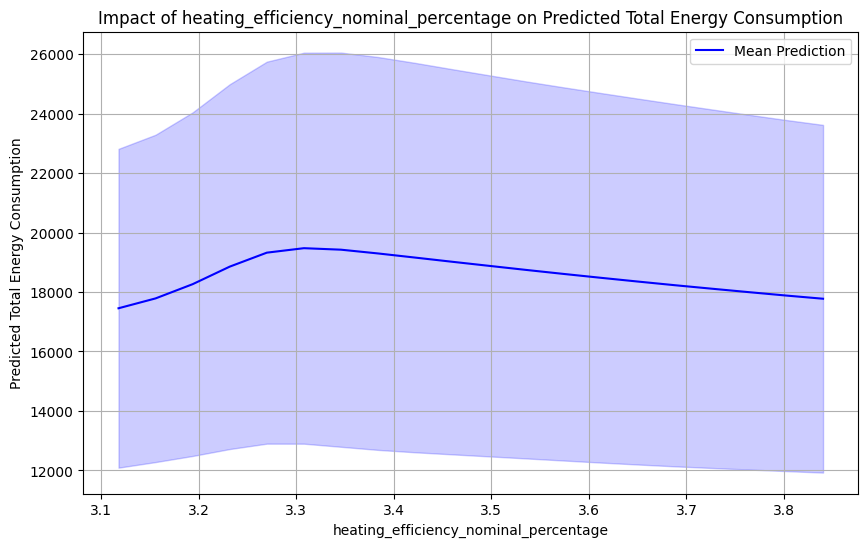

60/60 [==============================] - 2s 26ms/step


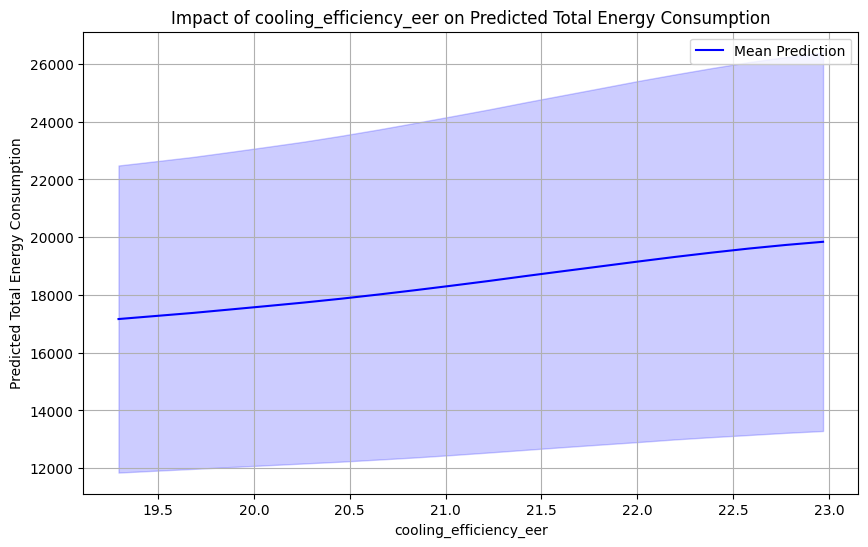

In [0]:
results = analyze_feature_impact(
    model=model, inference_data=inference_data, feature_name="heating_efficiency_nominal_percentage"
)

results = analyze_feature_impact(
    model=model, inference_data=inference_data, feature_name="cooling_efficiency_eer"
)

Okay now lets look at the model that also got to see all the performance curve parameters. Mohammad said that the hope for this model would be that it would learn to rely much less heavily on these somewhat less reliable rated specs and instead focus on the more reliable peformance curve metrics. 

And would you look at that--it learned to basically ignore these!

60/60 [==============================] - 2s 25ms/step


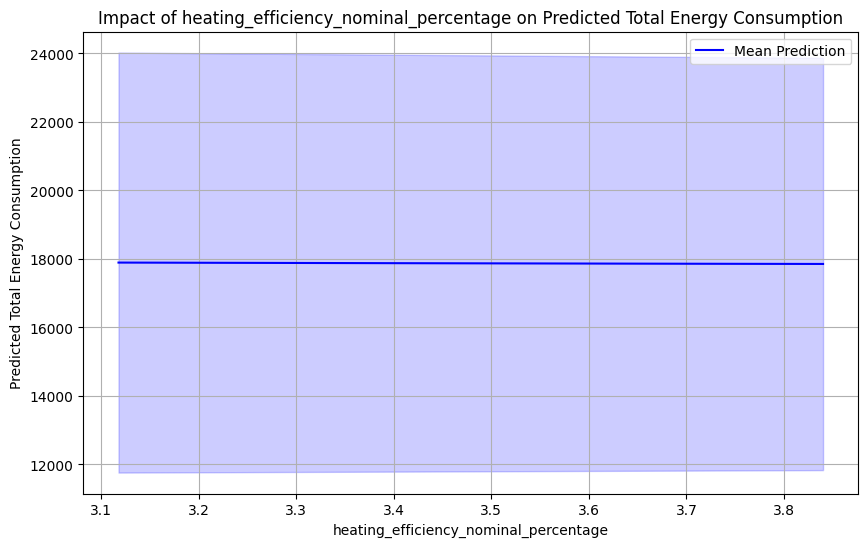

60/60 [==============================] - 2s 24ms/step


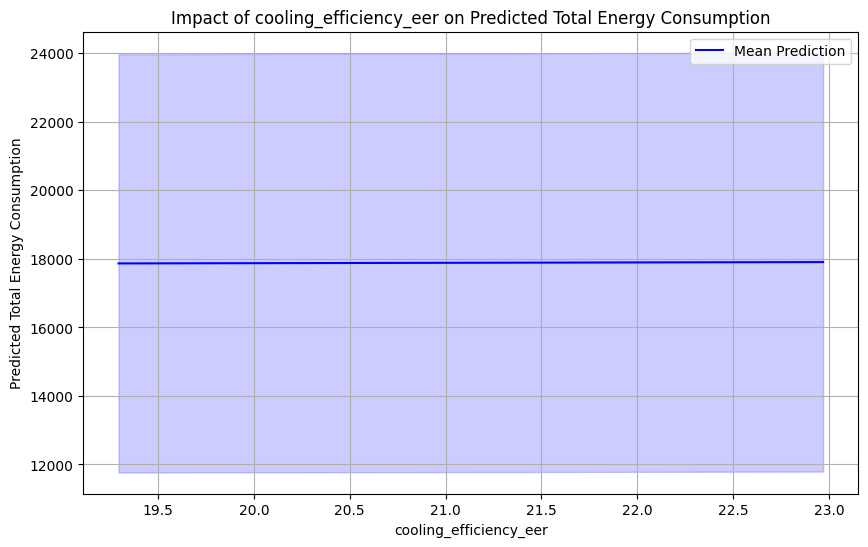

In [0]:
results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="heating_efficiency_nominal_percentage"
)

results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="cooling_efficiency_eer"
)

Looking at a few select performance curve params, it has instead learned these relationships correctly, at least directionally. The magnitude here probably shouldn't be taken too seriously. 

60/60 [==============================] - 2s 26ms/step


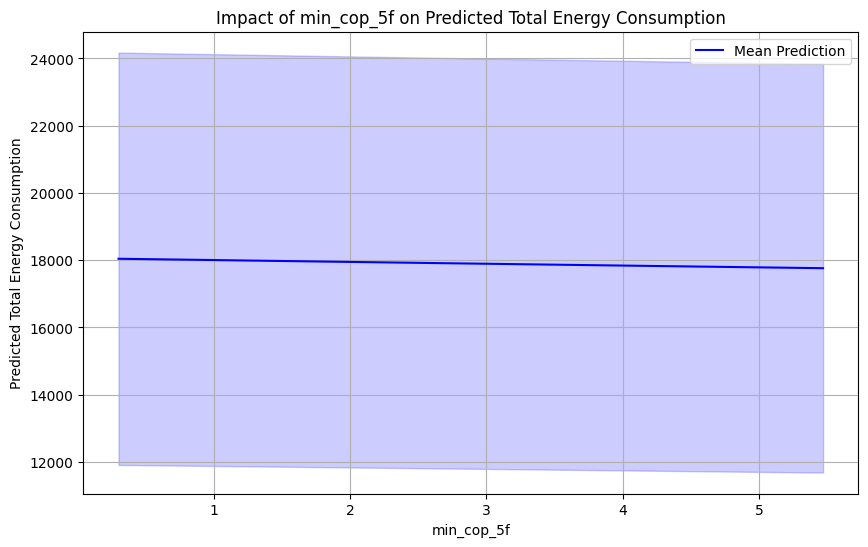

60/60 [==============================] - 2s 24ms/step


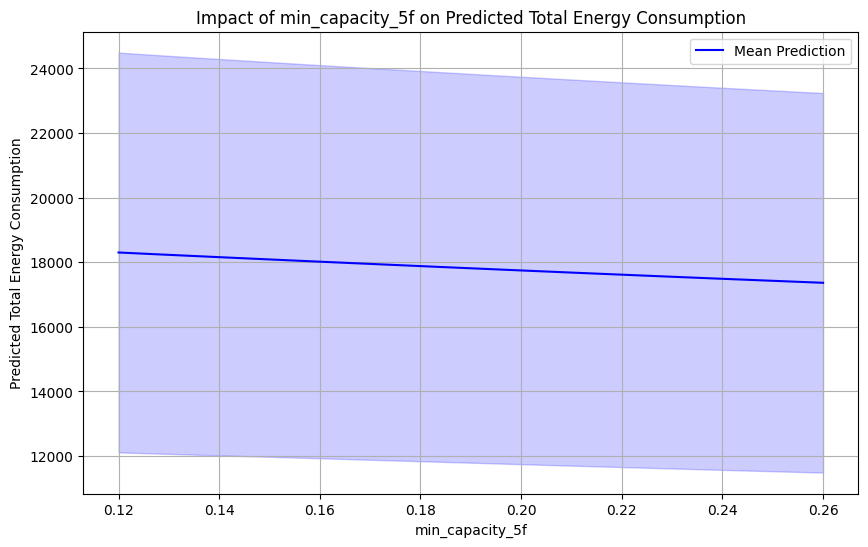

In [0]:
results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="min_cop_5f")

results = analyze_feature_impact(
    model=model_w_perf_metrics, inference_data=inference_data, feature_name="min_capacity_5f"
)